# Toxic Comment Classification using Natural Language Processing


# 1.LSTMModel

In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report  # Import classification_report function
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from collections import Counter  # Import Counter class for token counting
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the dataset
data = pd.read_csv("Toxic.csv")

In [3]:
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


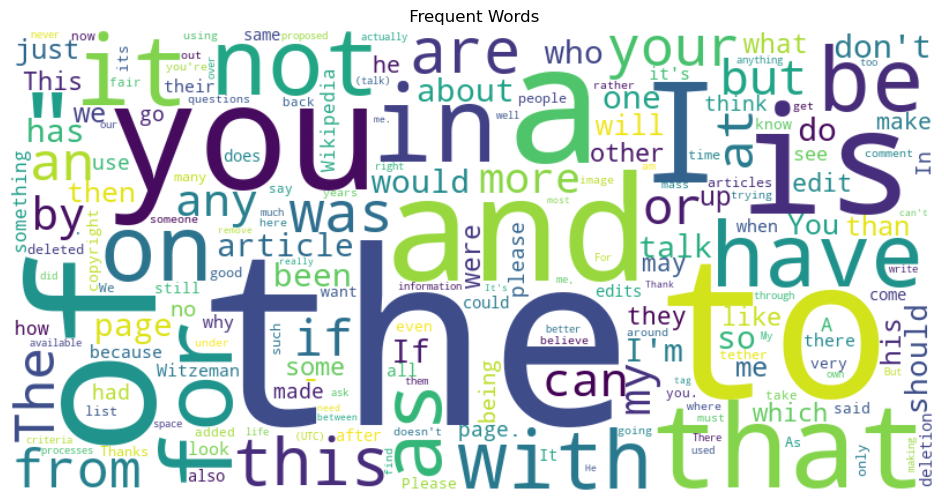

In [4]:
# Create vocabulary
all_comments = ' '.join(data['comment_text']).split()
word_freq = Counter(all_comments)

# Plot word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(' Frequent Words')
plt.show()

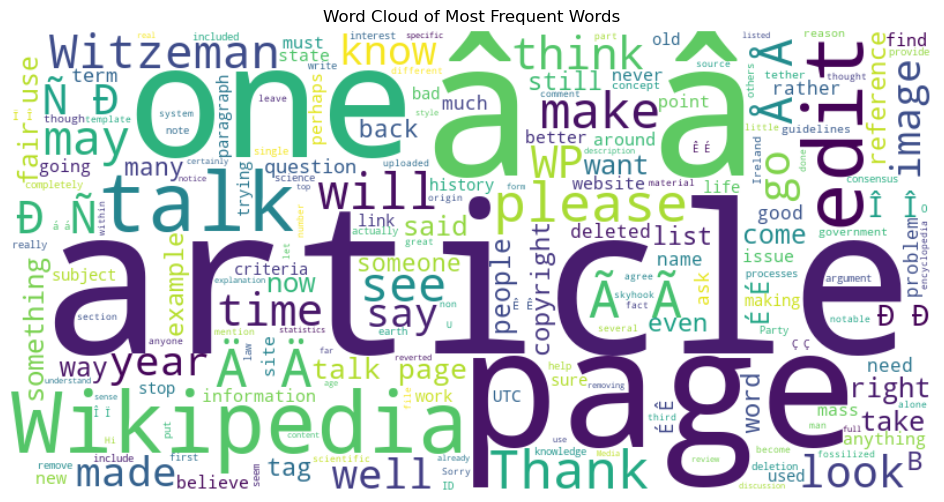

In [7]:
# Plot word cloud of most frequent words
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_comments))
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Frequent Words')
plt.show()

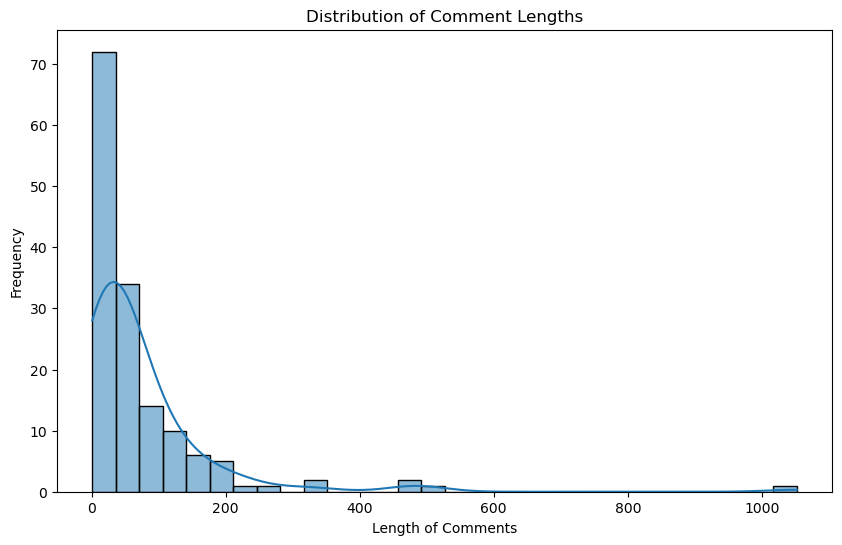

In [8]:
# Plot histogram of comment lengths
comment_lengths = [len(comment.split()) for comment in data['comment_text']]
plt.figure(figsize=(10, 6))
sns.histplot(comment_lengths, bins=30, kde=True)
plt.title('Distribution of Comment Lengths')
plt.xlabel('Length of Comments')
plt.ylabel('Frequency')
plt.show()

In [9]:
# Preprocessing
max_words = 10000  # Maximum number of words to tokenize
max_len = 100  # Maximum length of sequences

# Tokenize the comments and pad sequences
def tokenize_and_pad(text):
    tokens = text.split()[:max_len]
    token_ids = [vocab[token] for token in tokens if token in vocab]
    if len(token_ids) < max_len:
        token_ids += [0] * (max_len - len(token_ids))  # Padding with zeros if sequence is shorter
    return token_ids

In [10]:

# Create vocabulary
all_comments = ' '.join(data['comment_text']).split()
vocab = {token: idx + 1 for idx, (token, _) in enumerate(Counter(all_comments).most_common(max_words))}
vocab_size = len(vocab) + 1  # Add 1 for padding token

# Tokenize and pad the comments
X = [tokenize_and_pad(comment) for comment in data["comment_text"]]
X = torch.tensor(X)
y = torch.tensor(data.iloc[:, 2:].values, dtype=torch.float32)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [11]:
# Define the model architecture
class LSTMModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, num_layers, bidirectional, dropout):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, _ = self.lstm(embedded)
        hidden = self.dropout(torch.cat((output[:, -1, :hidden_dim], output[:, 0, hidden_dim:]), dim=1))
        return self.fc(hidden)

# Define dataset class
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [12]:

# Initialize model
embedding_dim = 100
hidden_dim = 256
output_dim = 6  # Number of output classes for toxicity types
num_layers = 2
bidirectional = True
dropout = 0.5
model = LSTMModel(embedding_dim, hidden_dim, output_dim, num_layers, bidirectional, dropout)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters())

# Convert data into DataLoader
train_dataset = CustomDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Training
epochs = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
train_losses = []
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}', leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_dataset)
    print(f'Training Loss: {epoch_loss:.4f}')
    train_losses.append(epoch_loss)


Training Loss: 0.6493


Training Loss: 0.5022


Training Loss: 0.3258


Training Loss: 0.1965


Training Loss: 0.1719


Training Loss: 0.1762


Training Loss: 0.1637


Training Loss: 0.1478


Training Loss: 0.1494


Training Loss: 0.1404


Training Loss: 0.1416


Training Loss: 0.1365


Training Loss: 0.1321


Training Loss: 0.1281


Training Loss: 0.1246


Training Loss: 0.1151


Training Loss: 0.1117


Training Loss: 0.1014


Training Loss: 0.0975


Training Loss: 0.0940


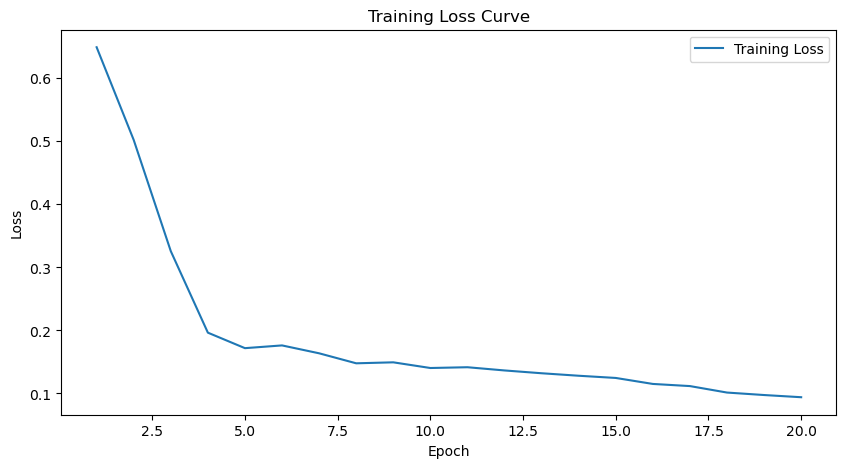

In [13]:
# Plot training loss curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [14]:
# Evaluation
model.eval()
y_pred = []
test_dataset = CustomDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)  # No need to shuffle for evaluation
with torch.no_grad():
    for inputs, _ in tqdm(test_loader, desc='Evaluating', leave=False):
        inputs = inputs.to(device)
        outputs = model(inputs)
        y_pred.extend(outputs.cpu().numpy())

y_pred = np.array(y_pred)

# Define class names
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Convert predictions and ground truth to binary labels
y_pred_binary = (y_pred > 0.5).astype(int)
y_test_binary = y_test.numpy().astype(int)

# Map binary labels to negative and positive
y_pred_labels = np.array([' | '.join([class_names[i] for i, val in enumerate(row) if val == 1]) if np.sum(row) > 0 else 'none' for row in y_pred_binary])
y_test_labels = np.array([' | '.join([class_names[i] for i, val in enumerate(row) if val == 1]) if np.sum(row) > 0 else 'none' for row in y_test_binary])

# Print classification report
print(classification_report(y_test_labels, y_pred_labels))

                                         precision    recall  f1-score   support

                                   none       0.90      1.00      0.95        27
                                  toxic       0.00      0.00      0.00         1
               toxic | obscene | insult       0.00      0.00      0.00         1
toxic | severe_toxic | obscene | insult       0.00      0.00      0.00         1

                               accuracy                           0.90        30
                              macro avg       0.23      0.25      0.24        30
                           weighted avg       0.81      0.90      0.85        30



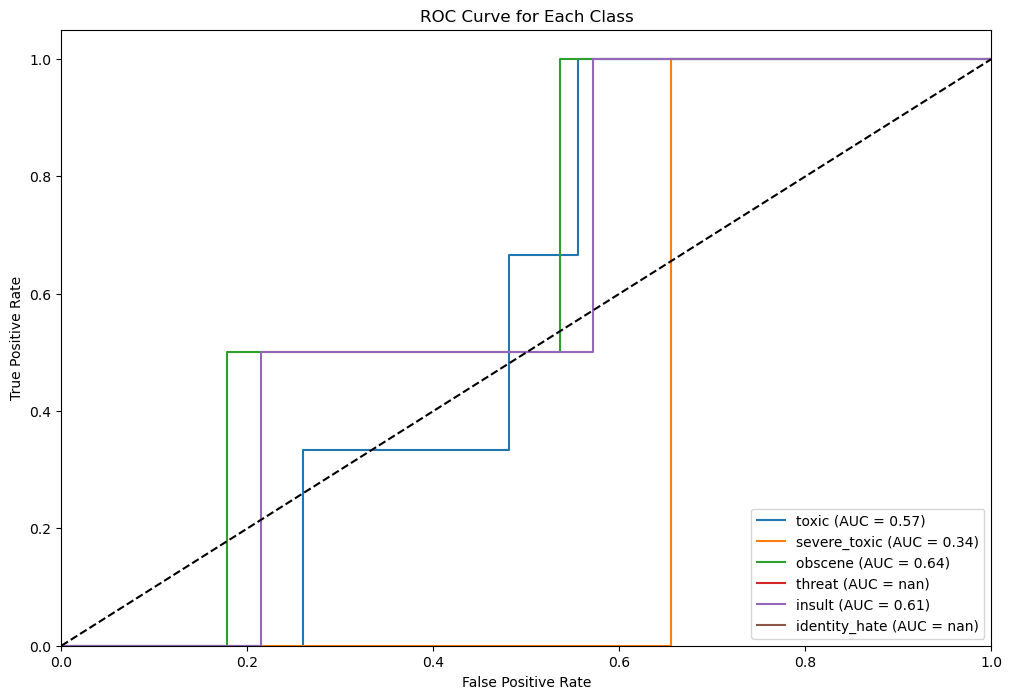

In [14]:
from sklearn.metrics import roc_curve, auc

# Evaluation
model.eval()
y_pred = []
test_dataset = CustomDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)  # No need to shuffle for evaluation
with torch.no_grad():
    for inputs, _ in tqdm(test_loader, desc='Evaluating', leave=False):
        inputs = inputs.to(device)
        outputs = model(inputs)
        y_pred.extend(outputs.cpu().numpy())

y_pred = np.array(y_pred)

# Define class names
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Convert predictions and ground truth to binary labels
y_pred_binary = (y_pred > 0.5).astype(int)
y_test_binary = y_test.numpy().astype(int)

# Plot ROC curves
plt.figure(figsize=(12, 8))
for i, class_name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_test_binary[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc="lower right")
plt.show()


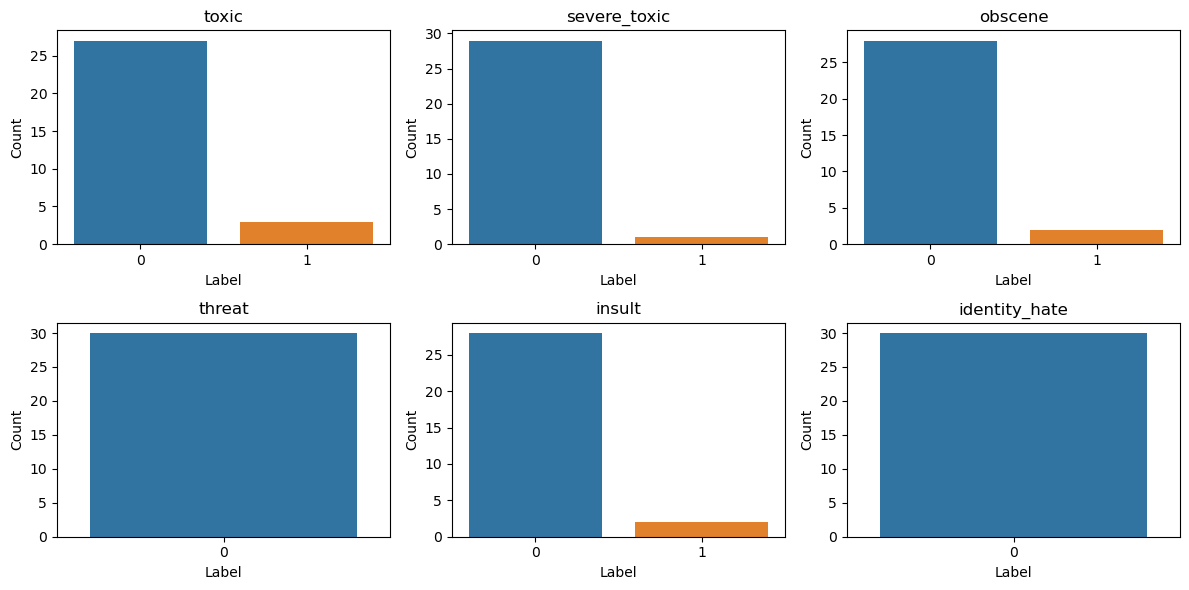

In [16]:
# Plot histograms of toxic categories
plt.figure(figsize=(12, 6))
for i, category in enumerate(class_names):
    plt.subplot(2, 3, i + 1)
    sns.countplot(x=y_test_binary[:, i])
    plt.title(category)
    plt.xlabel('Label')
    plt.ylabel('Count')
plt.tight_layout()
plt.show()


# 2.FeedForwardNN

In [5]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import warnings

In [7]:


# Hide all warnings
warnings.filterwarnings("ignore")

# Load the dataset
data = pd.read_csv("Toxic.csv")

# Preprocessing
max_words = 10000
max_len = 100

# Tokenize the comments and pad sequences
def tokenize_and_pad(text):
    tokens = text.split()[:max_len]
    token_ids = [vocab[token] for token in tokens if token in vocab]
    if len(token_ids) < max_len:
        token_ids += [0] * (max_len - len(token_ids))
    return token_ids

# Create vocabulary
all_comments = ' '.join(data['comment_text']).split()
vocab = {token: idx + 1 for idx, (token, _) in enumerate(Counter(all_comments).most_common(max_words))}
vocab_size = len(vocab) + 1

# Tokenize and pad the comments
X = [tokenize_and_pad(comment) for comment in data["comment_text"]]
X = torch.tensor(X)
y = torch.tensor(data.iloc[:, 2:].values, dtype=torch.float32)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model architecture
class FeedForwardNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, dropout):
        super(FeedForwardNN, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.fc1 = nn.Linear(max_len * embedding_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.embedding(text).view(text.size(0), -1)
        output = self.dropout(torch.relu(self.fc1(embedded)))
        return self.fc2(output)

# Define dataset class
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Initialize model
embedding_dim = 100
hidden_dim = 256
output_dim = 6
dropout = 0.5
model = FeedForwardNN(vocab_size, embedding_dim, hidden_dim, output_dim, dropout)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters())

# Convert data into DataLoader
train_dataset = CustomDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Training
epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
train_losses = []
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}', leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_dataset)
    print(f'Training Loss: {epoch_loss:.4f}')
    train_losses.append(epoch_loss)




Training Loss: 0.5787


Training Loss: 0.3225


Training Loss: 0.2958


Training Loss: 0.2443


Training Loss: 0.2019


Training Loss: 0.1378


Training Loss: 0.1565


Training Loss: 0.1220


Training Loss: 0.0773


Training Loss: 0.0905


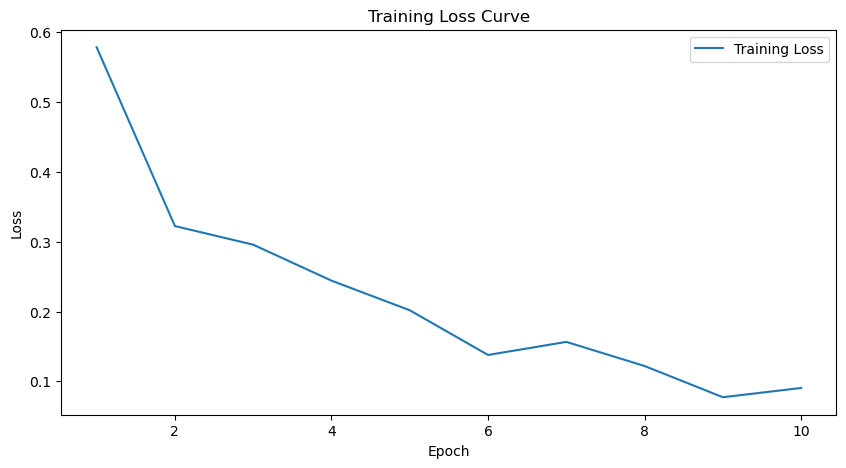

In [8]:
# Plot training loss curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

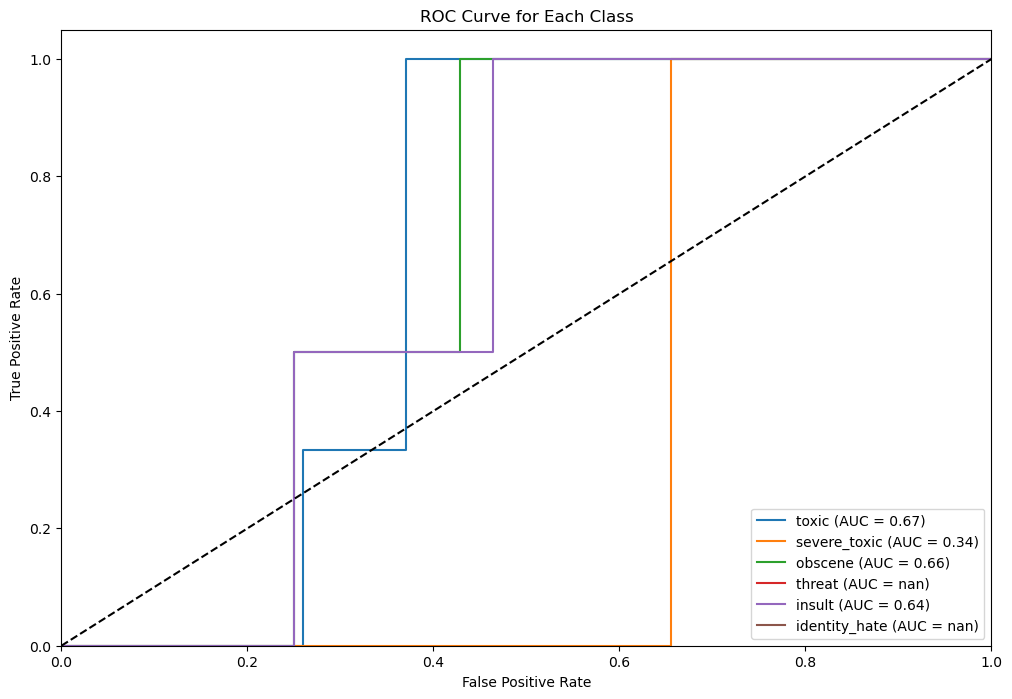

In [23]:


# Evaluation
model.eval()
y_pred = []
test_dataset = CustomDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
with torch.no_grad():
    for inputs, _ in tqdm(test_loader, desc='Evaluating', leave=False):
        inputs = inputs.to(device)
        outputs = model(inputs)
        y_pred.extend(outputs.cpu().numpy())

y_pred = np.array(y_pred)

# Define class names
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Convert predictions and ground truth to binary labels
y_pred_binary = (y_pred > 0.5).astype(int)
y_test_binary = y_test.numpy().astype(int)

# Plot ROC curves
plt.figure(figsize=(12, 8))
for i, class_name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_test_binary[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc="lower right")
plt.show()

# 3. CNN

In [25]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import warnings

# Hide all warnings
warnings.filterwarnings("ignore")

# Load the dataset
data = pd.read_csv("Toxic.csv")

# Preprocessing
max_words = 10000
max_len = 100

# Tokenize the comments and pad sequences
def tokenize_and_pad(text):
    tokens = text.split()[:max_len]
    token_ids = [vocab[token] for token in tokens if token in vocab]
    if len(token_ids) < max_len:
        token_ids += [0] * (max_len - len(token_ids))
    return token_ids

# Create vocabulary
all_comments = ' '.join(data['comment_text']).split()
vocab = {token: idx + 1 for idx, (token, _) in enumerate(Counter(all_comments).most_common(max_words))}
vocab_size = len(vocab) + 1

# Tokenize and pad the comments
X = [tokenize_and_pad(comment) for comment in data["comment_text"]]
X = torch.tensor(X)
y = torch.tensor(data.iloc[:, 2:].values, dtype=torch.float32)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model architecture (CNN)
class CNNModel(nn.Module):
    def __init__(self, embedding_dim, num_filters, filter_sizes, output_dim, dropout):
        super(CNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels=1, out_channels=num_filters, kernel_size=(fs, embedding_dim)) for fs in filter_sizes
        ])
        self.fc = nn.Linear(len(filter_sizes) * num_filters, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.embedding(text).unsqueeze(1)
        conved = [torch.relu(conv(embedded)).squeeze(3) for conv in self.convs]
        pooled = [nn.functional.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        cat = self.dropout(torch.cat(pooled, dim=1))
        return self.fc(cat)

# Define dataset class
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Initialize model
embedding_dim = 100
num_filters = 100
filter_sizes = [3, 4, 5]
output_dim = 6
dropout = 0.5
model = CNNModel(embedding_dim, num_filters, filter_sizes, output_dim, dropout)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters())

# Convert data into DataLoader
train_dataset = CustomDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Training
epochs = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
train_losses = []
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}', leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_dataset)
    print(f'Training Loss: {epoch_loss:.4f}')
    train_losses.append(epoch_loss)



Training Loss: 0.5131


Training Loss: 0.2740


Training Loss: 0.1768


Training Loss: 0.1351


Training Loss: 0.1234


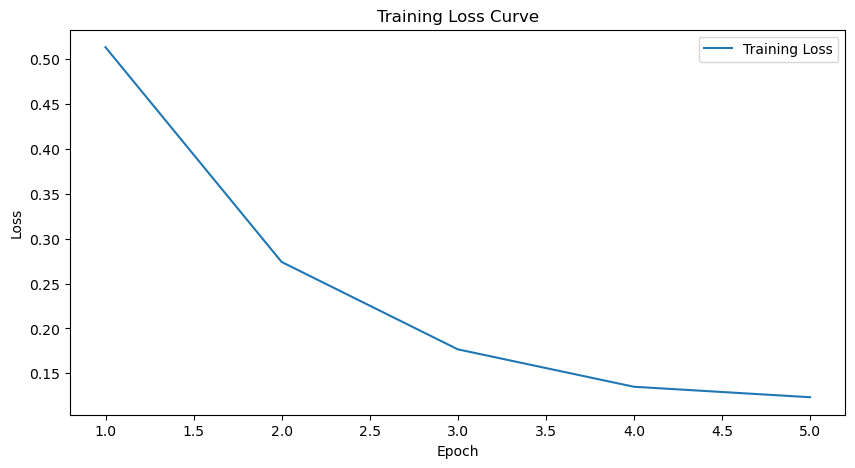

In [26]:

# Plot training loss curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


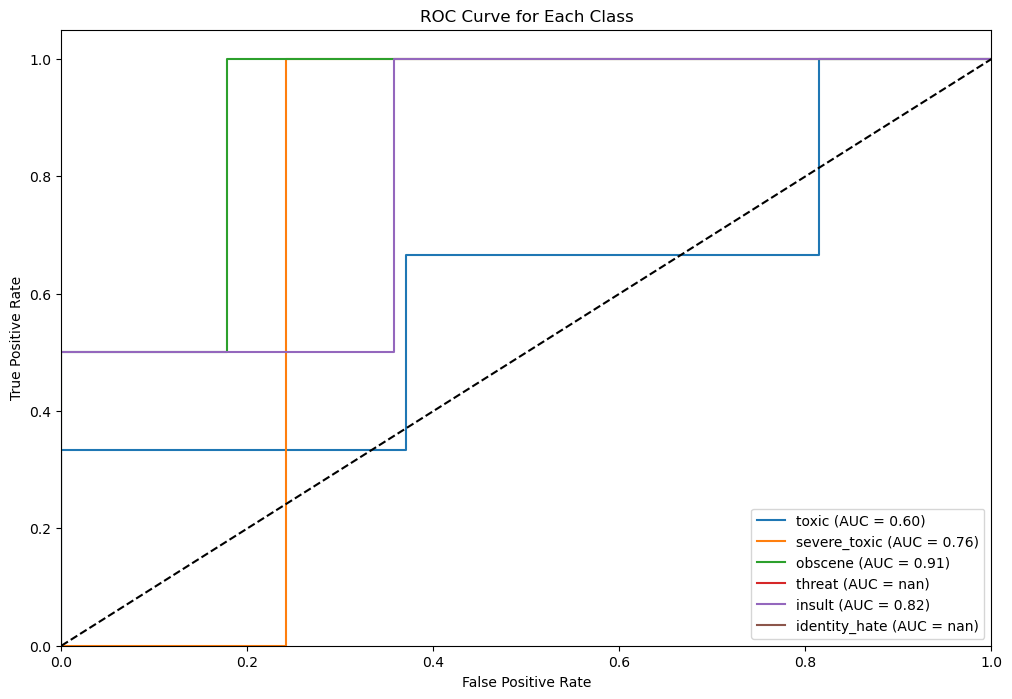

In [27]:
# Evaluation
model.eval()
y_pred = []
test_dataset = CustomDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
with torch.no_grad():
    for inputs, _ in tqdm(test_loader, desc='Evaluating', leave=False):
        inputs = inputs.to(device)
        outputs = model(inputs)
        y_pred.extend(outputs.cpu().numpy())

y_pred = np.array(y_pred)

# Define class names
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Convert predictions and ground truth to binary labels
y_pred_binary = (y_pred > 0.5).astype(int)
y_test_binary = y_test.numpy().astype(int)

# Plot ROC curves
plt.figure(figsize=(12, 8))
for i, class_name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_test_binary[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc="lower right")
plt.show()


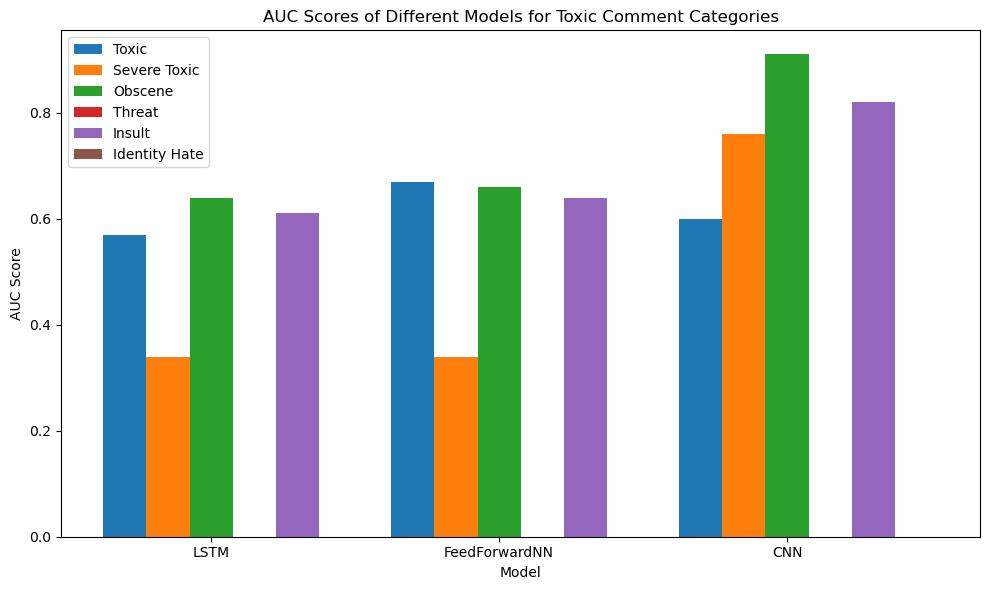

In [16]:
import matplotlib.pyplot as plt

# Define the data
models = ['LSTM', 'FeedForwardNN', 'CNN']
toxic_auc = [0.57, 0.67, 0.60]
severe_toxic_auc = [0.34, 0.34, 0.76]
obscene_auc = [0.64, 0.66, 0.91]
threat_auc = [0, 0, 0]  # Replace NaN with 0
insult_auc = [0.61, 0.64, 0.82]
identity_hate_auc = [0, 0, 0]  # Replace NaN with 0

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.15
index = range(len(models))

plt.bar(index, toxic_auc, bar_width, label='Toxic')
plt.bar([i + bar_width for i in index], severe_toxic_auc, bar_width, label='Severe Toxic')
plt.bar([i + 2 * bar_width for i in index], obscene_auc, bar_width, label='Obscene')
plt.bar([i + 3 * bar_width for i in index], threat_auc, bar_width, label='Threat')
plt.bar([i + 4 * bar_width for i in index], insult_auc, bar_width, label='Insult')
plt.bar([i + 5 * bar_width for i in index], identity_hate_auc, bar_width, label='Identity Hate')

plt.xlabel('Model')
plt.ylabel('AUC Score')
plt.title('AUC Scores of Different Models for Toxic Comment Categories')
plt.xticks([i + 2 * bar_width for i in index], models)
plt.legend()
plt.tight_layout()
plt.show()


# 4. Implementation

In [17]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from transformers import pipeline
from ipywidgets import interact, widgets, Layout
from IPython.display import display, HTML

# Load pre-trained sentiment analysis model from Hugging Face
sentiment_analysis = pipeline("sentiment-analysis")

# Define function for sentiment prediction
def predict_sentiment(text):
    result = sentiment_analysis(text)
    label = result[0]['label']
    sentiment = "Positive" if label == "POSITIVE" else "Negative" if label == "NEGATIVE" else "Neutral"
    return sentiment

# Create input widget for text
text_input = widgets.Textarea(
    value='',
    placeholder='Enter text here...',
    description='Text:',
    layout=Layout(width='50%', height='100px')
)

# Create output widget for sentiment
sentiment_output = widgets.Output()

# Define function to update sentiment output
def update_sentiment(change):
    sentiment_output.clear_output()
    with sentiment_output:
        sentiment = predict_sentiment(change.new)
        print(f'Sentiment: {sentiment}')

# Attach update function to text input
text_input.observe(update_sentiment, names='value')

# Display widgets
display(text_input)
display(sentiment_output)



No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Textarea(value='', description='Text:', layout=Layout(height='100px', width='50%'), placeholder='Enter text he…

Output()